This is a demonstration notebook on how to use the `nbody_python` module submitted with the rest of the code for ASTR 513 midterm project.

This project referenced [5 steps to N-body simulation](https://alvinng4.github.io/grav_sim/5_steps_to_n_body_simulation/) for explanations, optimizations and tricks & tips.

Let's start by importing the necessary modules.

In [1]:
import initialConditionsBuilder as IC
import nbody_python as nbd
#from nbody_python import leapfrog
#import make_gif as mkg

import numpy as np
from astropy import units as u # this is only used in the initial conditions builder for ease of access to value of pc.
import matplotlib.pyplot as plt

This is the cell where we build initial conditions (credit: Rafael Berlotto):

In [2]:
alphas = [2.03,0.3,-2.35] # Krouppa IMF power indices
mass_intervals = [0.01,0.1,1,50] # intervals for Krouppa IMF
R0 = 0.5*u.pc # radius in parsecs, feel free to change it
N = 50 # number of particles
ic = IC.initialConditions(N) # create initial conditions objects
ic.sample_piecewise_powerlaw(alphas = alphas, mass_intervals = mass_intervals) # create mass distribution in solar masses
ic.build_phasespace(nDim = 3,R0 = R0, model = 'plummer') # create Plummer sphere positions and velocities (in m and m/s)
posVels = ic.posVels # extract positions and velocities (x,y,z,vx,vy,vz) in m and m/s
masses = ic.masses # extract masses in solar masses

posVels = posVels.T # note that the output by ic is 6xN instead of Nx6, so we need one extra step of processing here.
init_pos = posVels[:, 0:3]
init_vel = posVels[:, 3:6] #everything in m/s works

Then we can build a system object by calling the `nbdsys` class contained in the python script:

In [3]:
sys = nbd.nbdsys(N, mass_list = masses, init_pos = init_pos, init_vel = init_vel)

To integrate: call the `integrate` method on the instance of `nbdsys`. 

You can specify which integration method you want to use when calling the method. The default is `leapfrog`. 

If you want to store the integration results, you have to allocate arrays in the beginning.

In [4]:
%%time

nsteps = int(100)                                          # total: 1e7 = 5 million years
dt = 3.15e9                                                # 100 years
t = np.arange(nsteps) * dt                                 # time array if needed. 
                                                           # As no adaptive timestep method has been implemented, this is not necessary.

sol_x = np.empty((nsteps, N, 3))                           # allocate array for x 
sol_v = np.empty((nsteps, N, 3))                           # similarly for v
dE = np.empty((nsteps,))                                   # this is the relative error array.
init_energy = nbd.energy(sys)                              # calculate the initial energy as a "standard" reference for later steps.
print(init_energy)                                         # Just a debug call. Note that this is in SI units (Joules) so it's pretty big.
for i in range(nsteps):
    sol_x[i] = sys.pos                                     # store the system's velocity and position in these two arrays
    sol_v[i] = sys.vel
    nbd.integrate(sys, dt, integrator = "leapfrog")        # integrate the system. 
                                                           # Change is made in place, so this method does not return anything.
    dE[i] = (nbd.energy(sys) - init_energy)/init_energy    # Calculate the relative energy error and store it in the error array. 
                                                           # While using abs() is advised, usually there is no need to do so as this is
                                                           # the relative error, and usually it doesn't flip sign.

-2.185589379786078e+37
CPU times: user 180 ms, sys: 3 μs, total: 180 ms
Wall time: 180 ms


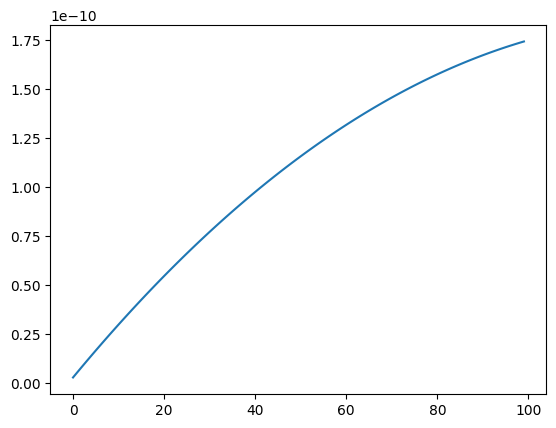

In [5]:
plt.plot(dE) # usually a log scale would work better, but this is only 100 steps it's not going to matter.

Another important available function is `energy`, which is used to calculate the energy in a given system at the current timestep, as can be seen above on the `nbd.energy(sys)` call. This is also used to calculate errors, as shown above. 

And that is all. Enjoy!

Additionally, if you want to make gifs (note that this method is **very slow**):

In [6]:
import make_gif as mkg

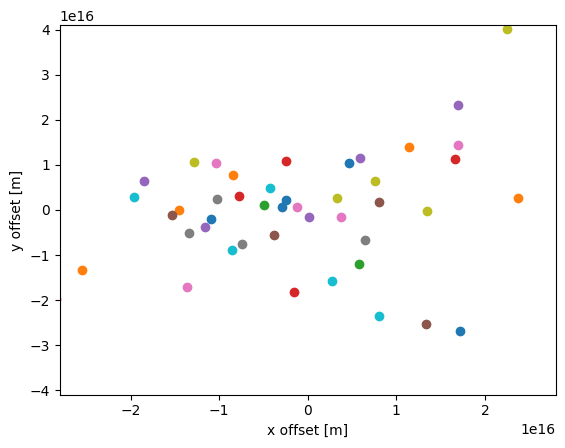

In [7]:
mkg.make_gif(sol_x, filename = "test", frames = 100)

And there you have a gif saved to `test.gif`!

For blackbody temperature colored ones, you can call `make_gif_bb` from the same module. Note that the colors do not have an interpolation routine, and are simply based off of `bb_colors.txt` from the nearest neighbor principle. 

Enjoy!